# SHAP with the Titanic (Practice)

Kris Barbier

In [1]:
## Our standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
## Preprocessing tools
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
## Models & evaluation metrics
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
## setting random state for reproducibility
SEED = 321
np.random.seed(SEED)


In [2]:
fname = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vR9Yhcch85ziIad4CyZQqLtYijHgsuENLfyC0YAXlajVbSC7U7s3CUUsfG-OYIKOjTI9DdKZH1xMs3a/pub?output=csv'
df= pd.read_csv(fname,index_col=0)
df


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S


In [3]:
# ### Train Test Split
## Make x and y variables
drop_feats = ["Name","Ticket","Cabin"]
y = df['Survived'].copy()
X = df.drop(columns=['Survived',*drop_feats]).copy()
## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
# ### Preprocessing + ColumnTransformer
## make categorical & numeric selectors
cat_sel = make_column_selector(dtype_include='object')
num_sel = make_column_selector(dtype_include='number')
## make pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='if_binary', sparse_output=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))
## make the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
## fit column transformer and run get_feature_names_out
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train), 
                          columns = feature_names, index = X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test), 
                          columns = feature_names, index = X_test.index)
X_test_df.head(3)


,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_MISSING,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
355,3.0,30.314472,0.0,0.0,7.225,1.0,1.0,0.0,0.0,0.0
519,2.0,36.000000,1.0,0.0,26.000,0.0,0.0,0.0,0.0,1.0
814,3.0,6.000000,4.0,2.0,31.275,0.0,0.0,0.0,0.0,1.0


In [4]:
## fit random forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier()
rf_clf.fit(X_train_df,y_train)


RandomForestClassifier()

In [5]:
def evaluate_classification(model, X_train,y_train,X_test,y_test,
                            normalize='true',cmap='Blues', figsize=(10,5)):
    header="\tCLASSIFICATION REPORT"
    dashes='--'*40
    print(f"{dashes}\n{header}\n{dashes}")
    ## training data
    print('[i] Training Data:')
    y_pred_train = model.predict(X_train)
    report_train = metrics.classification_report(y_train, y_pred_train)
    print(report_train)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_train,y_train,
                                                  normalize=normalize,
                                                   cmap=cmap,ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_train,y_train,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()

    fig.tight_layout()
    plt.show()

    print(dashes)
    ## test data
    print(f"[i] Test Data:")
    y_pred_test = model.predict(X_test)
    report_test = metrics.classification_report(y_test, y_pred_test)
    print(report_test)
    fig,ax = plt.subplots(figsize=figsize,ncols=2)
    metrics.ConfusionMatrixDisplay.from_estimator(model,X_test,y_test,
                                                  normalize=normalize,
                                                   cmap=cmap, ax=ax[0])
    metrics.RocCurveDisplay.from_estimator(model,X_test,y_test,ax=ax[1])
    ax[1].plot([0,1],[0,1],ls=':')
    ax[1].grid()
    fig.tight_layout()
    plt.show()


--------------------------------------------------------------------------------
	CLASSIFICATION REPORT
--------------------------------------------------------------------------------
[i] Training Data:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       419
           1       0.98      0.97      0.98       249

    accuracy                           0.98       668
   macro avg       0.98      0.98      0.98       668
weighted avg       0.98      0.98      0.98       668



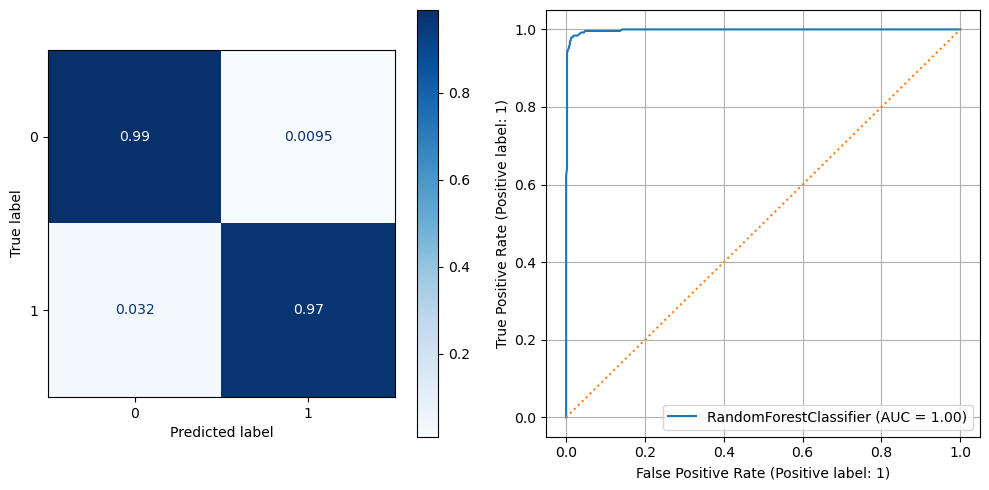

--------------------------------------------------------------------------------
[i] Test Data:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       130
           1       0.81      0.83      0.82        93

    accuracy                           0.85       223
   macro avg       0.84      0.84      0.84       223
weighted avg       0.85      0.85      0.85       223



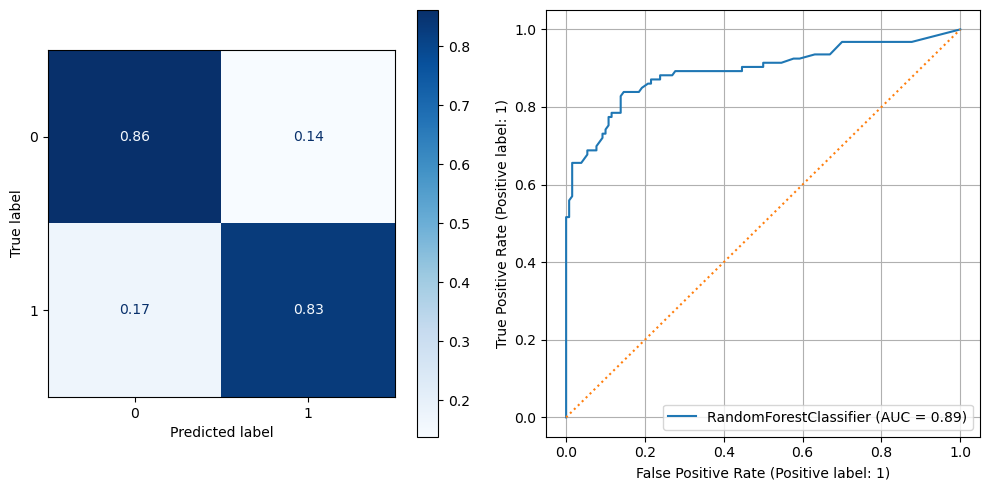

In [6]:
evaluate_classification(rf_clf,X_train_df,y_train, X_test_df,y_test)

In [7]:
# Import shap and initialize javascript:
import shap
shap.initjs()


In [8]:
len(X_train_df)


668

In [9]:
X_shap = shap.sample(X_train_df,nsamples=400,random_state=321)
X_shap.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_MISSING,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,
811,3.0,26.0,0.0,0.0,7.8875,1.0,0.0,0.0,0.0,1.0
736,3.0,28.5,0.0,0.0,16.1000,1.0,0.0,0.0,0.0,1.0
386,2.0,18.0,0.0,0.0,73.5000,1.0,0.0,0.0,0.0,1.0
290,3.0,22.0,0.0,0.0,7.7500,0.0,0.0,0.0,1.0,0.0
707,2.0,45.0,0.0,0.0,13.5000,0.0,0.0,0.0,0.0,1.0


In [10]:
## get the corresponding y-values
y_shap = y_train.loc[X_shap.index]
y_shap 

PassengerId
811    0
736    0
386    0
290    1
707    1
      ..
639    0
701    1
2      1
495    0
172    0
Name: Survived, Length: 400, dtype: int64

In [11]:
explainer = shap.Explainer(rf_clf)
explainer


In [12]:
## Getting the shap values
shap_values = explainer(X_shap,y_shap)
type(shap_values)

shap._explanation.Explanation

In [13]:
# slicing for dying values 
shap_vals_1 = shap_values[:,:,1]
shap_vals_1.shape

(400, 10)

In [14]:
pd.DataFrame(shap_vals_1.values, columns = X_shap.columns)


,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_MISSING,Embarked_Q,Embarked_S
0,-0.045220,0.021269,0.004702,-0.003341,-0.141929,-0.160772,-0.009718,-0.000012,-0.008925,-0.018045
1,-0.057410,-0.023499,0.007295,-0.005031,-0.042222,-0.184370,-0.015882,-0.000011,-0.004488,-0.016373
2,-0.070058,0.008629,-0.001290,-0.009811,0.005076,-0.228262,-0.025283,-0.000015,-0.000533,-0.020444
3,-0.063844,0.004795,0.014367,0.015217,0.012684,0.326203,-0.008738,-0.000009,-0.012098,0.002671
4,0.106056,-0.016690,0.050137,0.007178,0.028766,0.412772,0.000935,-0.000015,0.000190,-0.001319
...,...,...,...,...,...,...,...,...,...,...
395,-0.184326,-0.098063,0.011326,-0.165617,-0.011359,0.161429,-0.021377,-0.000035,-0.001481,-0.014487
396,0.139015,0.024934,0.023202,0.014474,0.068600,0.263283,0.045392,-0.000021,0.001602,0.027527
397,0.178852,-0.028549,0.027998,0.006874,0.126145,0.241667,0.048780,-0.000038,0.002142,0.024137
398,-0.066303,-0.048190,-0.001475,-0.008163,-0.089197,-0.119661,-0.014280,-0.000012,-0.004825,-0.019885


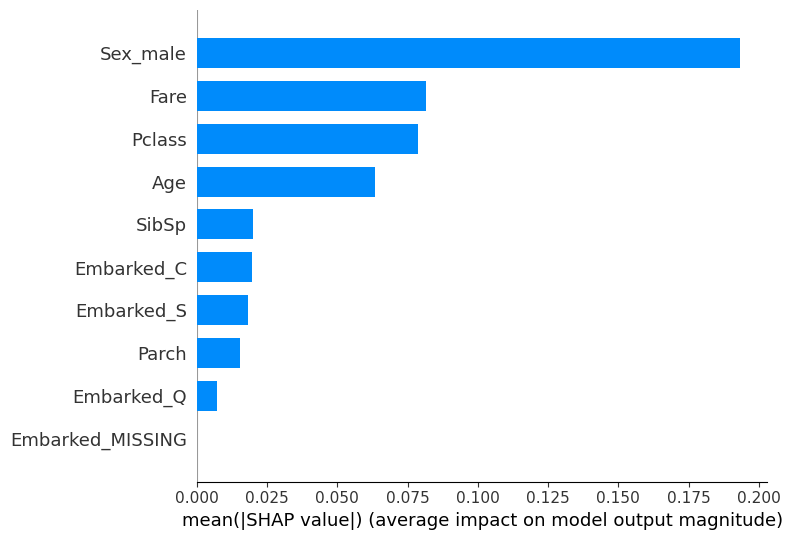

In [15]:
shap.summary_plot(shap_vals_1,features= X_shap, plot_type='bar')


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


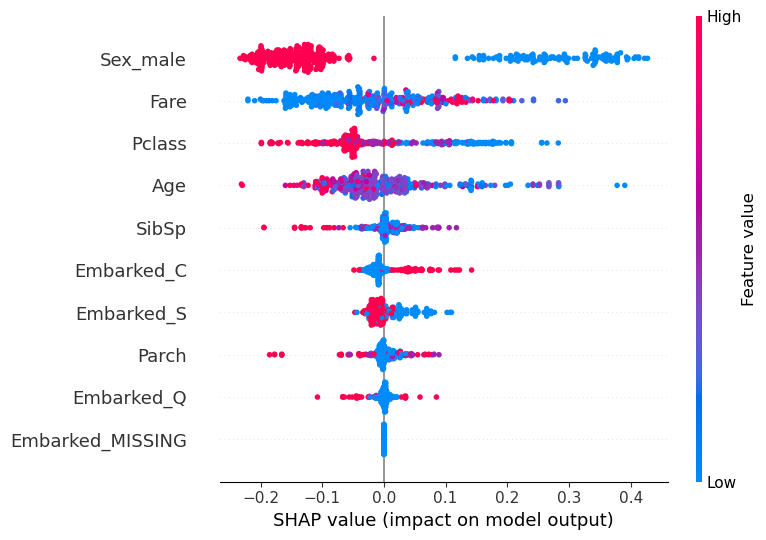

In [16]:
shap.summary_plot(shap_vals_1,X_shap)


## Interpretation

- The top 5 columns are Sex_male, Fare, Pclass, Age, and SibSp. These 5 columns make the most sense to be the top used columns for predictions.

    - According to the plot, male passengers are grouped on the left of the 0 line. This means that being male decreases a passenger's chances of surviving the sinking, which makes sense based on what we know.
    - To the opposite effect, what type of fare passengers paid for their tickets increases their likelihood of surviving.
    - Pclass however, do not make as much sense. Both of these have higher values placed to the left of the 0 line, which means that higher values of this feature will decrease their likelihood of surviving. Higher classes led to more survivals, which is opposite of this plot.
    - Age makes sense, as higher ages tended to not survive.
    - Finally, higher values in the siblings/spouses feature led to decreased survivability.